In [2]:
import os
import sys

# Get the path to the parent directory
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

# Now you can import your modules
from src.data.openbb_datamodule import OpenBBDataModule

/home/itachi/Programming/Utokyo/LabSuzumura/StockProject/alphadl/venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [4]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [5]:
# Instantiate the data module
data_module = OpenBBDataModule(
    index="sp500",
    train_date=["2024-01-01", "2024-09-30"],
    val_date=["2024-10-01", "2024-11-05"],
    test_date=["2024-11-05", "2024-11-07"],
    interval="1m",
    market="US",
    sequence_length=240,
    batch_size=64,
    cache_dir="../data",
    use_cache=True,
    provider="fmp",
    openbb_output_type="dataframe",
    max_prediction_length=120,
    selected_tickers=["AAPL", "MSFT"],
)

# Prepare the data
data_module.prepare_data()

# Access the datasets
train_data = data_module.train_data
val_data = data_module.val_data
test_data = data_module.test_data

# Display the first few rows of each dataset
print("Train Data:")
print(train_data.shape)

print("\nValidation Data:")
print(val_data.shape)

print("\nTest Data:")
print(test_data.shape)
test_data

INFO:src.data.openbb_datamodule:Loading data from cache files in: ../data/US/1m/sp500


Train Data:
(145500, 10)

Validation Data:
(20280, 10)

Test Data:
(780, 10)


,open,high,low,close,volume,ticker,date,month,day,time_idx
83280,222.61,222.94,221.19,221.20,1706976,AAPL,2024-11-06 09:30:00,11,6,83280
83281,221.25,223.13,221.23,223.10,574636,AAPL,2024-11-06 09:31:00,11,6,83281
83282,223.09,224.57,223.08,224.21,605913,AAPL,2024-11-06 09:32:00,11,6,83282
83283,224.18,224.51,224.11,224.18,406538,AAPL,2024-11-06 09:33:00,11,6,83283
83284,224.19,225.22,224.09,225.19,476851,AAPL,2024-11-06 09:34:00,11,6,83284
...,...,...,...,...,...,...,...,...,...,...
167725,419.35,420.45,419.35,420.11,260750,MSFT,2024-11-06 15:55:00,11,6,83665
167726,420.09,420.31,420.02,420.25,142474,MSFT,2024-11-06 15:56:00,11,6,83666
167727,420.25,420.27,420.10,420.10,152690,MSFT,2024-11-06 15:57:00,11,6,83667
167728,420.11,420.19,419.71,419.75,216732,MSFT,2024-11-06 15:58:00,11,6,83668


In [6]:
data_module.setup()

# Access the training TimeSeriesDataSet
training = data_module.training
validation = data_module.validation

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

INFO:src.data.openbb_datamodule:Setting up data sequences


In [7]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.2942, device='cuda:0')

In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Adam",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 9.3k


Finding best initial lr:   2%|▏         | 2/100 [00:00<00:17,  5.57it/s]

Finding best initial lr: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.030199517204020167
Restoring states from the checkpoint path at /home/itachi/Programming/Utokyo/LabSuzumura/StockProject/alphadl/notebooks/.lr_find_1ad76c66-8cd7-4ce3-9c93-c5c24b8f29a8.ckpt
Restored all states from the checkpoint at /home/itachi/Programming/Utokyo/LabSuzumura/StockProject/alphadl/notebooks/.lr_find_1ad76c66-8cd7-4ce3-9c93-c5c24b8f29a8.ckpt


suggested learning rate: 0.030199517204020167


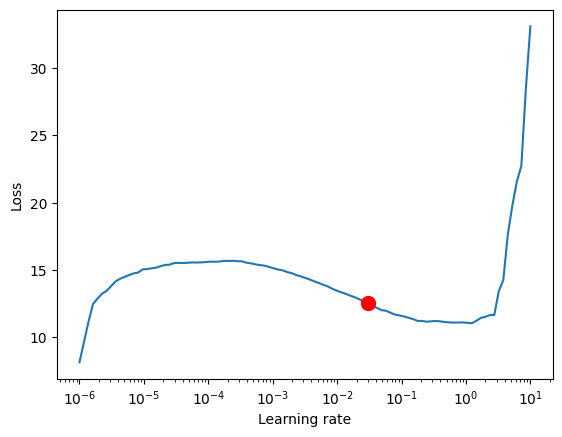

In [9]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [10]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import lightning.pytorch as pl

# Also the way callbacks are imported should be slightly modified.
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# Configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # comment in for training, running validation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Initialize the TemporalFusionTransformer
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.030,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Fit the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variab

Number of parameters in network: 22.5k
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 36: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s, v_num=5, train_loss_step=0.276, val_loss=0.147, train_loss_epoch=0.218] 


In [29]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [30]:
# calculate mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

tensor(0.2905)

In [13]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True
)
print(raw_predictions.x.keys())
print(raw_predictions.x["groups"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
tensor([[0],
        [1]], device='cuda:0')


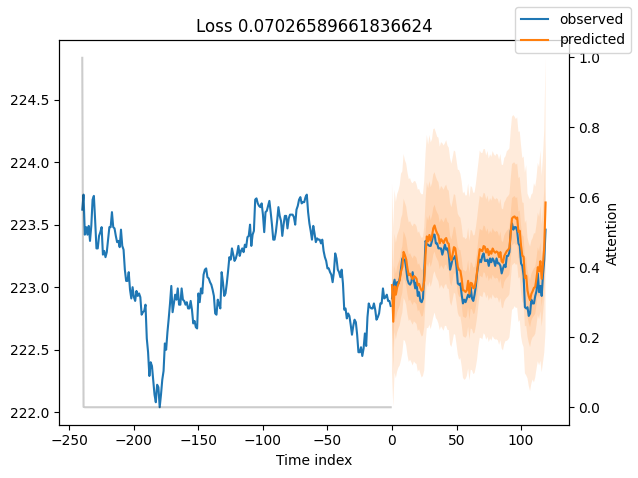

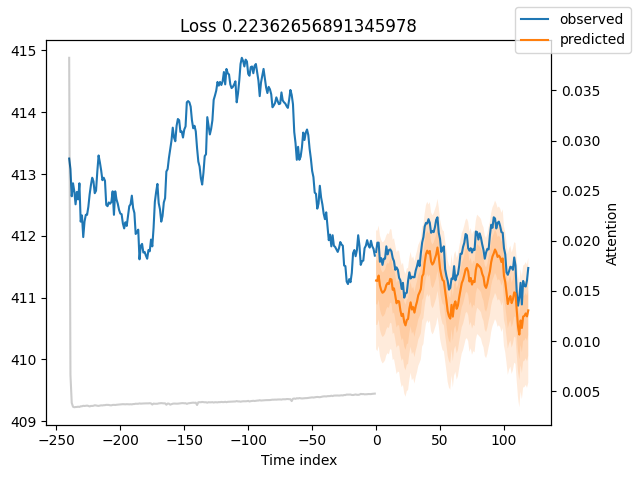

In [14]:
for idx in range(2):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


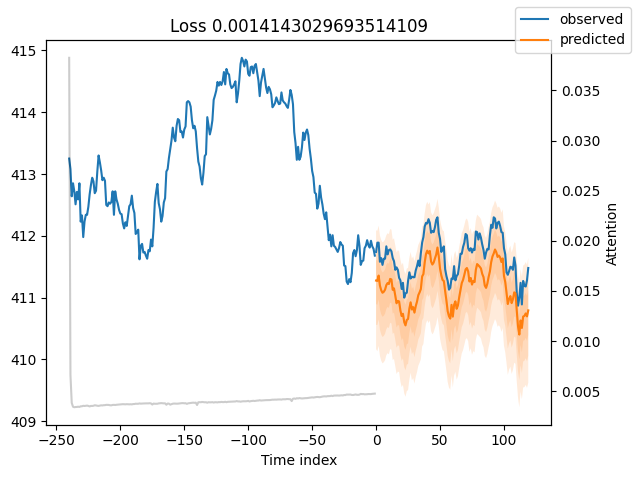

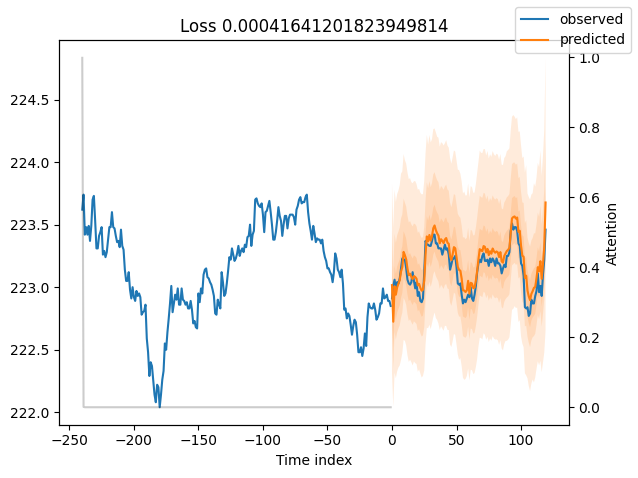

In [15]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(2):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

In [16]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(0.2905)

In [17]:
val_df = pd.read_csv("../data/US/1m/sp500/val.csv")
val_df.columns = [col.capitalize() for col in val_df.columns]
val_df.set_index("Date", inplace=True)
val_df.index = pd.to_datetime(val_df.index)
print(val_df.shape)
val_df


(20280, 10)


,Unnamed: 0,Open,High,Low,Close,Volume,Ticker,Month,Day,Time_idx
Date,,,,,,,,,,
2024-10-01 09:30:00,73140,229.52,229.65,228.40,228.75,1813892,AAPL,10,1,73140
2024-10-01 09:31:00,73141,228.77,228.77,228.25,228.53,705430,AAPL,10,1,73141
2024-10-01 09:32:00,73142,228.47,228.58,227.36,227.66,773370,AAPL,10,1,73142
2024-10-01 09:33:00,73143,227.67,227.95,227.25,227.28,504207,AAPL,10,1,73143
2024-10-01 09:34:00,73144,227.26,227.72,227.06,227.65,419639,AAPL,10,1,73144
...,...,...,...,...,...,...,...,...,...,...
2024-11-05 15:55:00,167335,410.89,411.49,410.86,411.27,113022,MSFT,11,5,83275
2024-11-05 15:56:00,167336,411.27,411.32,411.07,411.19,62400,MSFT,11,5,83276
2024-11-05 15:57:00,167337,411.19,411.33,411.16,411.18,79165,MSFT,11,5,83277


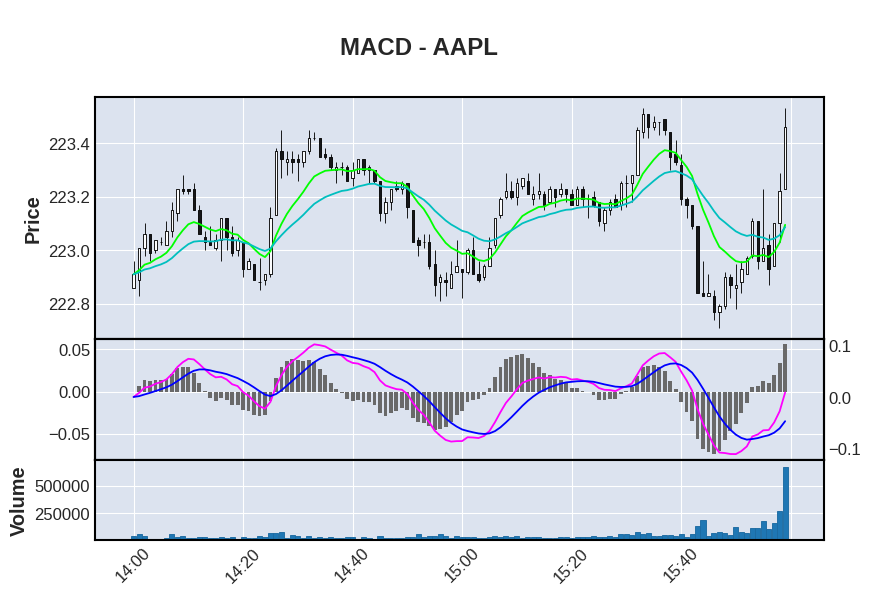

In [18]:
import mplfinance as mpf

# Correct the symbol name
symbol = "AAPL"  # Ensure this matches the 'Ticker' column exactly
df = val_df.loc[val_df["Ticker"] == symbol]
df = df.iloc[-120:]

# Define reference time

exp12 = df["Close"].ewm(span=12, adjust=False).mean()
exp26 = df["Close"].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26

signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

apds = [
    mpf.make_addplot(exp12, color="lime"),
    mpf.make_addplot(exp26, color="c"),
    mpf.make_addplot(
        histogram,
        type="bar",
        width=0.7,
        panel=1,
        color="dimgray",
        alpha=1,
        secondary_y=False,
    ),
    mpf.make_addplot(macd, panel=1, color="fuchsia", secondary_y=True),
    mpf.make_addplot(signal, panel=1, color="b", secondary_y=True),
]

mpf.plot(
    df,
    type="candle",
    addplot=apds,
    figscale=1.1,
    figratio=(8, 5),
    title="\nMACD - " + symbol,
    volume=True,
    volume_panel=2,
    panel_ratios=(6, 3, 2),
)

In [19]:
test_df = pd.read_csv("../data/US/1m/sp500/test.csv")
test_df.columns = [col.capitalize() for col in test_df.columns]
test_df.set_index("Date", inplace=True)
test_df.index = pd.to_datetime(test_df.index)
print(test_df.shape)
test_df

(780, 10)


,Unnamed: 0,Open,High,Low,Close,Volume,Ticker,Month,Day,Time_idx
Date,,,,,,,,,,
2024-11-06 09:30:00,83280,222.61,222.94,221.19,221.20,1706976,AAPL,11,6,83280
2024-11-06 09:31:00,83281,221.25,223.13,221.23,223.10,574636,AAPL,11,6,83281
2024-11-06 09:32:00,83282,223.09,224.57,223.08,224.21,605913,AAPL,11,6,83282
2024-11-06 09:33:00,83283,224.18,224.51,224.11,224.18,406538,AAPL,11,6,83283
2024-11-06 09:34:00,83284,224.19,225.22,224.09,225.19,476851,AAPL,11,6,83284
...,...,...,...,...,...,...,...,...,...,...
2024-11-06 15:55:00,167725,419.35,420.45,419.35,420.11,260750,MSFT,11,6,83665
2024-11-06 15:56:00,167726,420.09,420.31,420.02,420.25,142474,MSFT,11,6,83666
2024-11-06 15:57:00,167727,420.25,420.27,420.10,420.10,152690,MSFT,11,6,83667


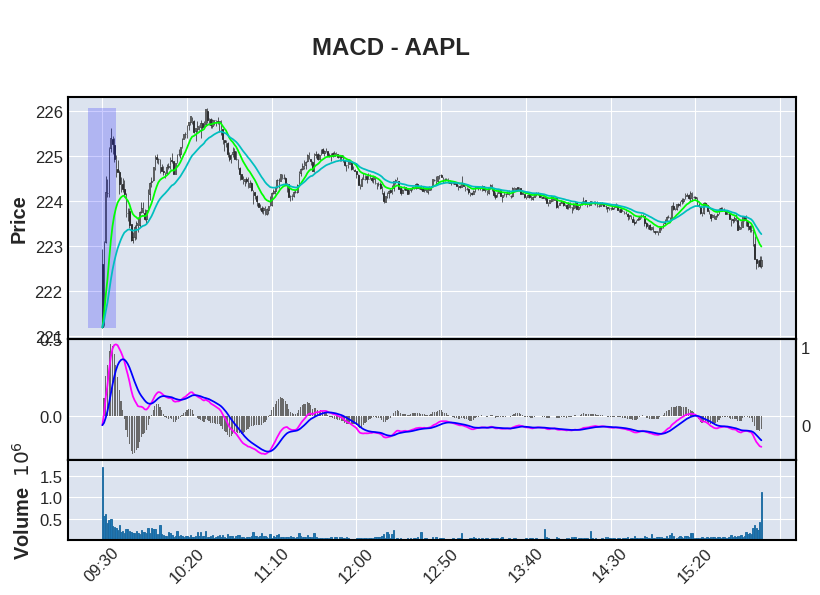

In [20]:
import mplfinance as mpf

# Correct the symbol name
symbol = "AAPL"  # Ensure this matches the 'Ticker' column exactly
df = test_df.loc[test_df["Ticker"] == symbol]

# Define reference time
ref_time = "2024-11-06 09:30:00"

exp12 = df["Close"].ewm(span=12, adjust=False).mean()
exp26 = df["Close"].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26

signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

apds = [
    mpf.make_addplot(exp12, color="lime"),
    mpf.make_addplot(exp26, color="c"),
    mpf.make_addplot(
        histogram,
        type="bar",
        width=0.7,
        panel=1,
        color="dimgray",
        alpha=1,
        secondary_y=False,
    ),
    mpf.make_addplot(macd, panel=1, color="fuchsia", secondary_y=True),
    mpf.make_addplot(signal, panel=1, color="b", secondary_y=True),
]

mpf.plot(
    df,
    type="candle",
    addplot=apds,
    figscale=1.1,
    figratio=(8, 5),
    title="\nMACD - " + symbol,
    volume=True,
    volume_panel=2,
    panel_ratios=(6, 3, 2),
    vlines=dict(vlines=ref_time, linewidths=20, alpha=0.2, colors="blue"),
)

In [21]:
test_raw_df = pd.read_csv("../data/US/1m/sp500/test.csv")
print(test_raw_df.loc[test_raw_df["ticker"] == "AAPL"].shape)
test_raw_df.head()

(390, 11)


,Unnamed: 0,open,high,low,close,volume,ticker,date,month,day,time_idx
0,83280,222.61,222.94,221.19,221.20,1706976,AAPL,2024-11-06 09:30:00,11,6,83280
1,83281,221.25,223.13,221.23,223.10,574636,AAPL,2024-11-06 09:31:00,11,6,83281
2,83282,223.09,224.57,223.08,224.21,605913,AAPL,2024-11-06 09:32:00,11,6,83282
3,83283,224.18,224.51,224.11,224.18,406538,AAPL,2024-11-06 09:33:00,11,6,83283
4,83284,224.19,225.22,224.09,225.19,476851,AAPL,2024-11-06 09:34:00,11,6,83284


In [22]:
predictions = best_tft.predict(test_raw_df, mode="raw", return_x=True)

print(predictions.output.prediction.size())
print(predictions.output.prediction[0].size())
print(predictions.output.prediction)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([2, 120, 7])
torch.Size([120, 7])
tensor([[[223.3774, 223.7158, 223.8742,  ..., 224.2615, 224.5484, 224.9622],
         [223.2571, 223.5871, 223.7523,  ..., 224.1324, 224.4021, 224.7762],
         [223.2843, 223.6267, 223.7900,  ..., 224.1717, 224.4462, 224.8313],
         ...,
         [222.1359, 222.5505, 222.7238,  ..., 223.1162, 223.4258, 223.9097],
         [222.1316, 222.5926, 222.7733,  ..., 223.1759, 223.5120, 224.0686],
         [221.8709, 222.7623, 222.8228,  ..., 223.2916, 223.8165, 224.6308]],

        [[416.8586, 417.2429, 417.5592,  ..., 418.1534, 418.3378, 418.5344],
         [416.8506, 417.2577, 417.5672,  ..., 418.1618, 418.3515, 418.5440],
         [416.9538, 417.3579, 417.6683,  ..., 418.2620, 418.4506, 418.6401],
         ...,
         [418.7341, 419.1284, 419.4456,  ..., 420.0387, 420.2364, 420.4416],
         [418.5561, 418.9516, 419.2697,  ..., 419.8626, 420.0605, 420.2666],
         [418.6132, 419.0164, 419.3369,  ..., 419.9332, 420.1375, 420.3597]]],

In [23]:
predicted_values = (
    predictions.output.prediction[0, :, 3].cpu().numpy()
)  # Assuming the 4th index is the median

pred_df = pd.DataFrame(
    {"Predicted": predicted_values}, index=test_raw_df.date[: len(predicted_values)]
)  # Align with the actual data's time index
print(pred_df.shape)
pred_df

(120, 1)


,Predicted
date,
2024-11-06 09:30:00,224.092148
2024-11-06 09:31:00,223.964050
2024-11-06 09:32:00,224.005280
2024-11-06 09:33:00,223.997665
2024-11-06 09:34:00,223.973694
...,...
2024-11-06 11:25:00,223.190506
2024-11-06 11:26:00,222.946854
2024-11-06 11:27:00,222.968155


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


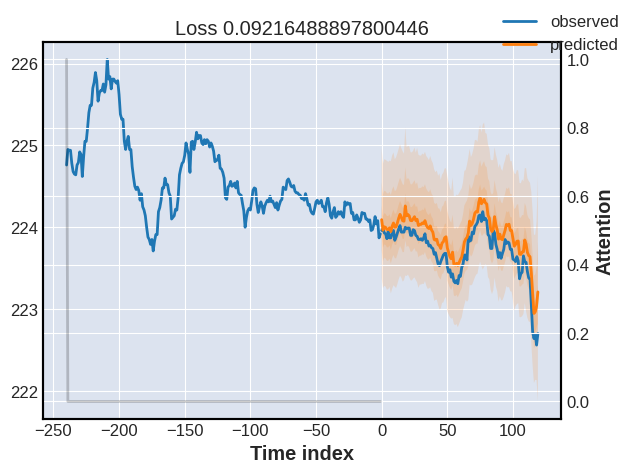

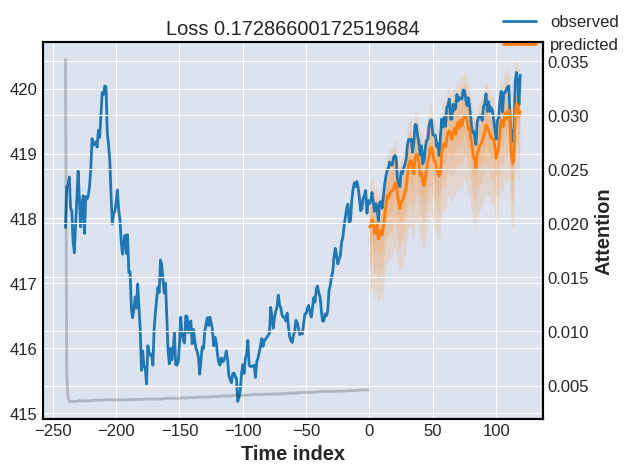

In [24]:
new_raw_predictions = best_tft.predict(test_raw_df, mode="raw", return_x=True)

for idx in range(2):  # plot 10 examples
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        add_loss_to_title=True,
    )

In [25]:
symbol = "AAPL"  # Ensure this matches the 'Ticker' column exactly
df = test_raw_df.loc[test_raw_df["ticker"] == symbol]
df.set_index("date", inplace=True)
df.head()

,Unnamed: 0,open,high,low,close,volume,ticker,month,day,time_idx
date,,,,,,,,,,
2024-11-06 09:30:00,83280,222.61,222.94,221.19,221.20,1706976,AAPL,11,6,83280
2024-11-06 09:31:00,83281,221.25,223.13,221.23,223.10,574636,AAPL,11,6,83281
2024-11-06 09:32:00,83282,223.09,224.57,223.08,224.21,605913,AAPL,11,6,83282
2024-11-06 09:33:00,83283,224.18,224.51,224.11,224.18,406538,AAPL,11,6,83283
2024-11-06 09:34:00,83284,224.19,225.22,224.09,225.19,476851,AAPL,11,6,83284


In [26]:
true_df = df.loc[pred_df.index]
true_df

,Unnamed: 0,open,high,low,close,volume,ticker,month,day,time_idx
date,,,,,,,,,,
2024-11-06 09:30:00,83280,222.61,222.94,221.19,221.20,1706976,AAPL,11,6,83280
2024-11-06 09:31:00,83281,221.25,223.13,221.23,223.10,574636,AAPL,11,6,83281
2024-11-06 09:32:00,83282,223.09,224.57,223.08,224.21,605913,AAPL,11,6,83282
2024-11-06 09:33:00,83283,224.18,224.51,224.11,224.18,406538,AAPL,11,6,83283
2024-11-06 09:34:00,83284,224.19,225.22,224.09,225.19,476851,AAPL,11,6,83284
...,...,...,...,...,...,...,...,...,...,...
2024-11-06 11:25:00,83395,224.20,224.39,224.19,224.36,86510,AAPL,11,6,83395
2024-11-06 11:26:00,83396,224.37,224.67,224.34,224.64,162651,AAPL,11,6,83396
2024-11-06 11:27:00,83397,224.64,224.74,224.57,224.72,101673,AAPL,11,6,83397


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


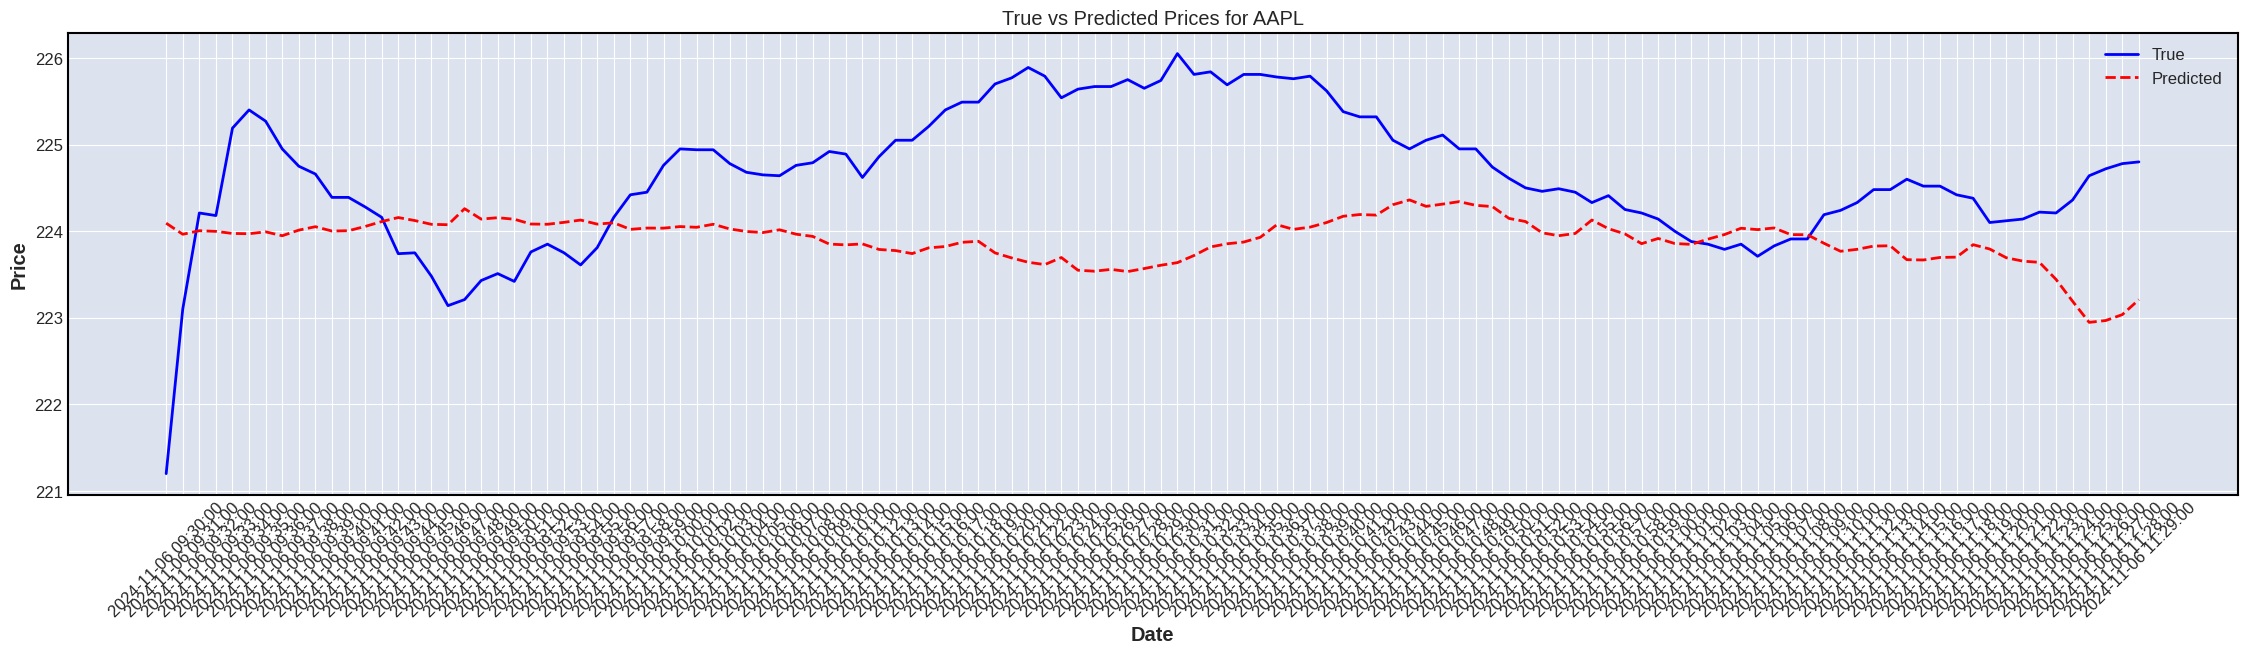

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting
plt.figure(figsize=(28, 6))
plt.plot(true_df.index, true_df['close'], label='True', color='blue')
plt.plot(pred_df.index, pred_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title(f"True vs Predicted Prices for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")

# Set major locator to increase spacing between x-ticks
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

In [28]:
df

,Unnamed: 0,open,high,low,close,volume,ticker,month,day,time_idx
date,,,,,,,,,,
2024-11-06 09:30:00,83280,222.61,222.94,221.19,221.20,1706976,AAPL,11,6,83280
2024-11-06 09:31:00,83281,221.25,223.13,221.23,223.10,574636,AAPL,11,6,83281
2024-11-06 09:32:00,83282,223.09,224.57,223.08,224.21,605913,AAPL,11,6,83282
2024-11-06 09:33:00,83283,224.18,224.51,224.11,224.18,406538,AAPL,11,6,83283
2024-11-06 09:34:00,83284,224.19,225.22,224.09,225.19,476851,AAPL,11,6,83284
...,...,...,...,...,...,...,...,...,...,...
2024-11-06 15:55:00,83665,223.06,223.24,222.71,222.72,360469,AAPL,11,6,83665
2024-11-06 15:56:00,83666,222.71,222.72,222.50,222.64,293751,AAPL,11,6,83666
2024-11-06 15:57:00,83667,222.64,222.70,222.55,222.69,252856,AAPL,11,6,83667
